# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

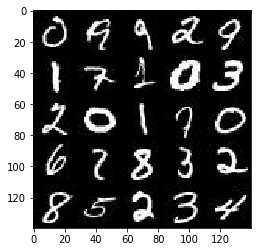

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

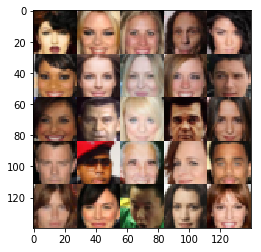

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [20]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):
    return tf.maximum(x, alpha * x, name=name)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* (1 - smooth)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3]) 
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.7121... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.8155
Epoch 1/2... Discriminator Loss: 1.7668... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.9392... Generator Loss: 2.8042
Epoch 1/2... Discriminator Loss: 1.5987... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.6194... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.3771
Epoch 1/2... Discriminator Loss: 0.7970... Generator Loss: 1.5569
Epoch 1/2... Discriminator Loss: 0.8395... Generator Loss: 1.3153
Epoch 1/2... Discriminator Loss: 0.7382... Generator Loss: 1.7653


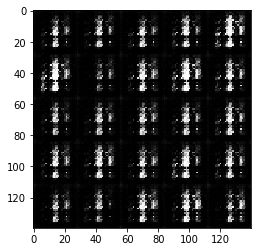

Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 2.6453
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 1.5189
Epoch 1/2... Discriminator Loss: 1.0349... Generator Loss: 1.4445
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.5379
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 0.6064... Generator Loss: 2.4808
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.3694
Epoch 1/2... Discriminator Loss: 0.8931... Generator Loss: 1.8888
Epoch 1/2... Discriminator Loss: 0.8100... Generator Loss: 2.0105


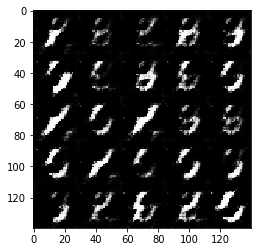

Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 1.4314
Epoch 1/2... Discriminator Loss: 0.7922... Generator Loss: 1.7302
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 1.3727
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 1.2533... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.5154
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.4792
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.2466
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 1.5049
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 1.3848


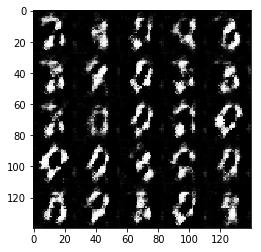

Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 1.1777
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.9162
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 1.6518
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 1.9023
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.9325
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.9890
Epoch 1/2... Discriminator Loss: 1.5174... Generator Loss: 0.9234
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 1.2070


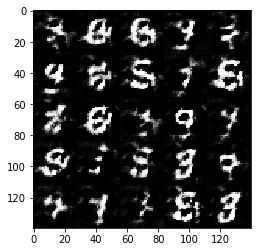

Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.2626
Epoch 1/2... Discriminator Loss: 1.3251... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.9107
Epoch 1/2... Discriminator Loss: 1.3210... Generator Loss: 1.3910
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 1.0257
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.4152
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 1.0363
Epoch 1/2... Discriminator Loss: 1.2085... Generator Loss: 0.8352
Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 1.3444


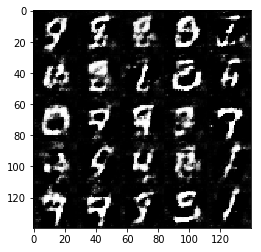

Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 1.3749
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.6135
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 1.0330
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.2176
Epoch 1/2... Discriminator Loss: 1.3682... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.1731... Generator Loss: 0.9496
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 1.2461


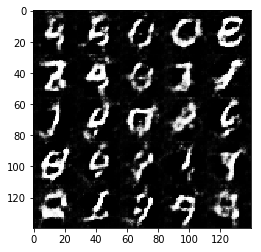

Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 0.9357
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.5186... Generator Loss: 0.5899
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.7435
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 1.3301... Generator Loss: 1.5088
Epoch 1/2... Discriminator Loss: 1.2250... Generator Loss: 0.9504
Epoch 1/2... Discriminator Loss: 1.3328... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.2823... Generator Loss: 0.7288


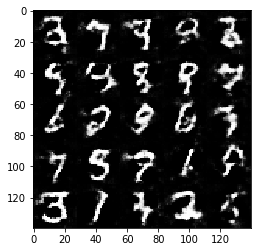

Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.9908
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.4974... Generator Loss: 1.5326
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 1.2811... Generator Loss: 1.0004
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 1.0736
Epoch 1/2... Discriminator Loss: 1.2806... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.2922... Generator Loss: 0.9317


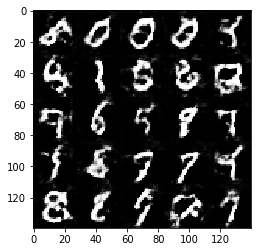

Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.2928... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.2863... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.6652
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 1.2883... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.5776... Generator Loss: 0.5338


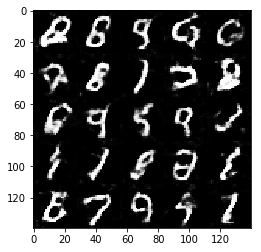

Epoch 1/2... Discriminator Loss: 1.5108... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 1.0753
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.6836
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.8066
Epoch 2/2... Discriminator Loss: 1.5153... Generator Loss: 1.2746
Epoch 2/2... Discriminator Loss: 1.3306... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 1.4487... Generator Loss: 1.2224
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.4117... Generator Loss: 0.9000
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.9144


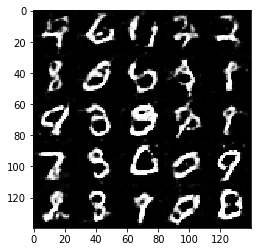

Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 1.2083
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 1.3954... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 1.2926... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 1.2174
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.9418


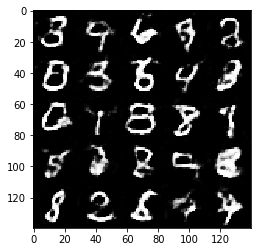

Epoch 2/2... Discriminator Loss: 1.3049... Generator Loss: 1.2135
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.9258
Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.7531
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.7463
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.4182... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 1.5304... Generator Loss: 1.3729
Epoch 2/2... Discriminator Loss: 1.2800... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.5538... Generator Loss: 0.5116
Epoch 2/2... Discriminator Loss: 1.5513... Generator Loss: 0.5579


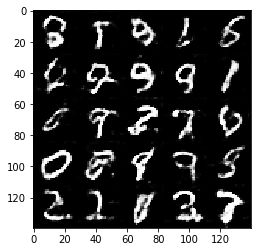

Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 1.2577... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6236
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.6294
Epoch 2/2... Discriminator Loss: 1.7702... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 1.2861... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 1.1190
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.5345


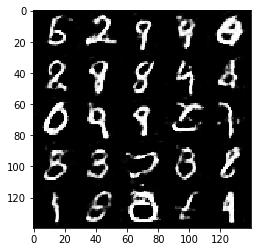

Epoch 2/2... Discriminator Loss: 1.2698... Generator Loss: 0.9139
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.4082... Generator Loss: 0.6224
Epoch 2/2... Discriminator Loss: 1.4190... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.2711... Generator Loss: 0.7735
Epoch 2/2... Discriminator Loss: 1.2756... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 1.2657
Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 1.4627
Epoch 2/2... Discriminator Loss: 1.3858... Generator Loss: 1.4474


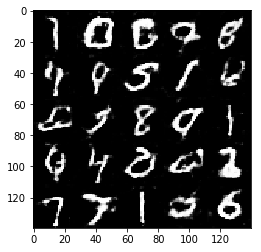

Epoch 2/2... Discriminator Loss: 1.3325... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.5067... Generator Loss: 0.5275
Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.4973... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 1.2383... Generator Loss: 0.6923
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 1.1778
Epoch 2/2... Discriminator Loss: 1.2411... Generator Loss: 0.6651
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.6344


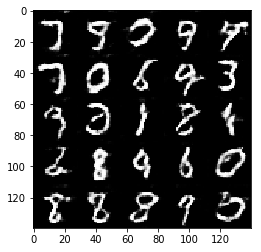

Epoch 2/2... Discriminator Loss: 1.7141... Generator Loss: 0.4340
Epoch 2/2... Discriminator Loss: 1.3184... Generator Loss: 0.6094
Epoch 2/2... Discriminator Loss: 1.4456... Generator Loss: 0.5526
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.5549
Epoch 2/2... Discriminator Loss: 1.3580... Generator Loss: 0.5886
Epoch 2/2... Discriminator Loss: 2.2764... Generator Loss: 0.3698
Epoch 2/2... Discriminator Loss: 1.3408... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.5789
Epoch 2/2... Discriminator Loss: 1.4739... Generator Loss: 0.5565


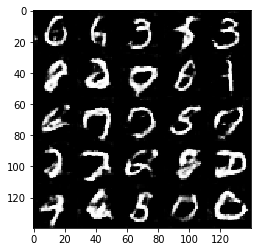

Epoch 2/2... Discriminator Loss: 1.6864... Generator Loss: 0.4469
Epoch 2/2... Discriminator Loss: 1.2564... Generator Loss: 0.7887
Epoch 2/2... Discriminator Loss: 1.2293... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.2632... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.7032
Epoch 2/2... Discriminator Loss: 1.2496... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 0.7353
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.9422
Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.8101


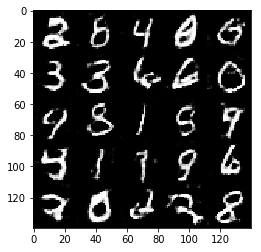

Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.8888
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 1.2000
Epoch 2/2... Discriminator Loss: 1.2883... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 1.3629... Generator Loss: 0.6225
Epoch 2/2... Discriminator Loss: 1.3035... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.5920
Epoch 2/2... Discriminator Loss: 1.5241... Generator Loss: 1.9160
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3293... Generator Loss: 0.6219


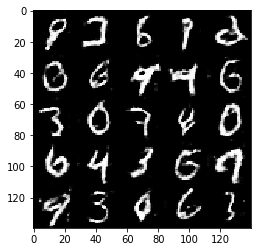

Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 1.0171
Epoch 2/2... Discriminator Loss: 1.4903... Generator Loss: 0.5271
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 1.2899
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.1311... Generator Loss: 0.8330
Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 1.1697


In [33]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.1367... Generator Loss: 0.4157
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.8550... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 1.0041
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 1.9752
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.7994
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 1.3396
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 2.0953


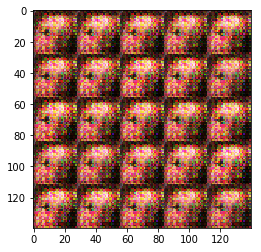

Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 1.8326
Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.9272
Epoch 1/1... Discriminator Loss: 0.6490... Generator Loss: 1.9777
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.5774
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.3274
Epoch 1/1... Discriminator Loss: 0.6696... Generator Loss: 1.9441
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.7543
Epoch 1/1... Discriminator Loss: 0.5735... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.2609
Epoch 1/1... Discriminator Loss: 0.6962... Generator Loss: 1.8407


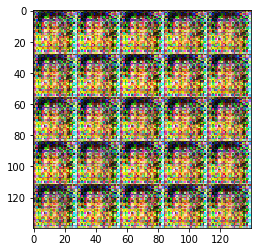

Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 2.2831
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 2.0608... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 1.0601


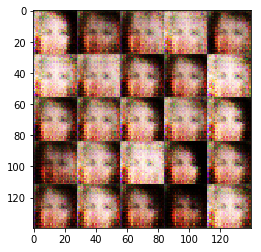

Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.7729... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.6597... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 1.0019


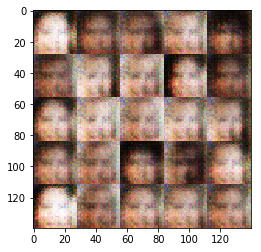

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.9467
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.6915... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.7221


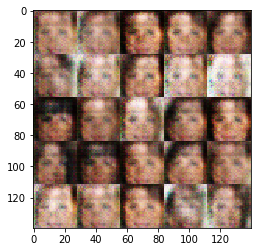

Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7876


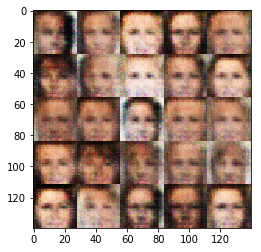

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.6494... Generator Loss: 0.7594


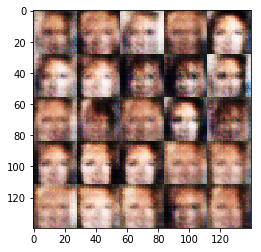

Epoch 1/1... Discriminator Loss: 1.5258... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5226... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7309


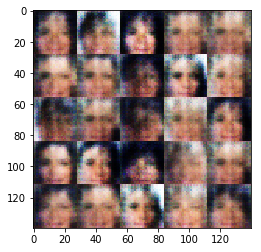

Epoch 1/1... Discriminator Loss: 1.6486... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.6738... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7914


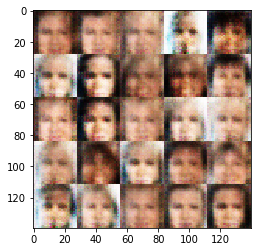

Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7748


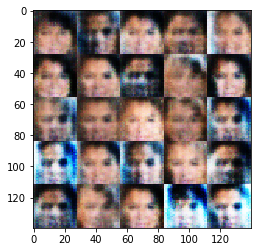

Epoch 1/1... Discriminator Loss: 1.5735... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.8145


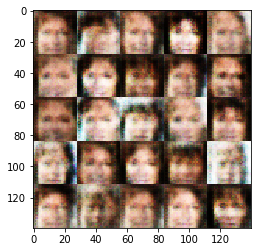

Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7353


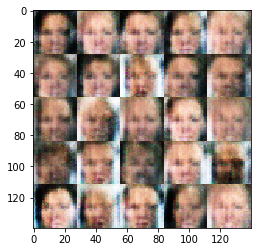

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.8082


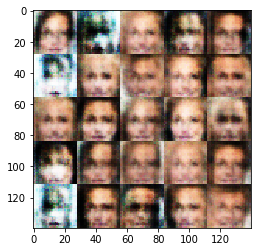

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7946


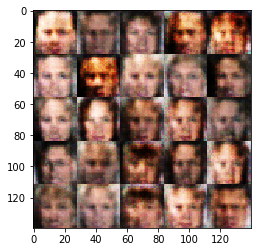

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.5210... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7828


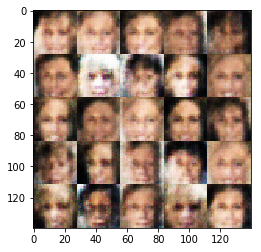

Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.8162


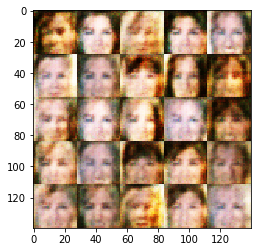

Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8029


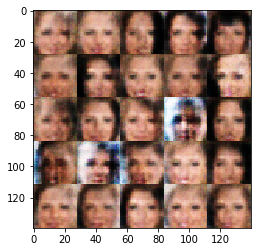

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7829


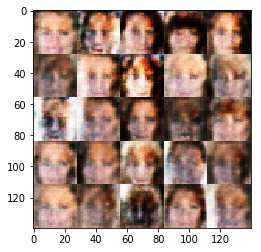

Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7666


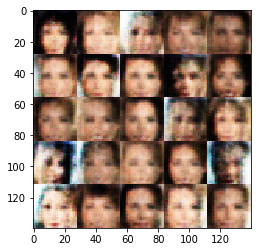

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8176


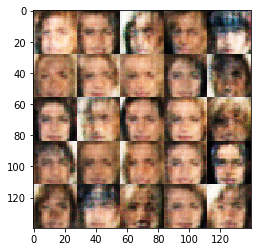

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7898


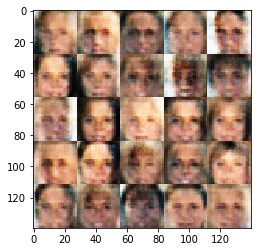

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7645


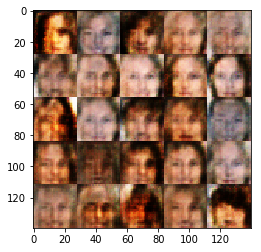

Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7986


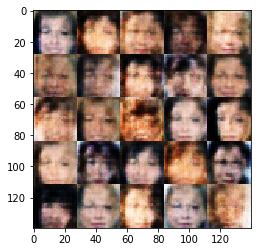

Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8510


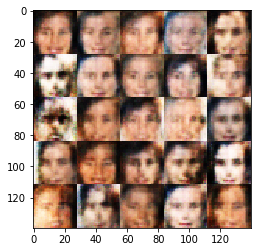

Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8053


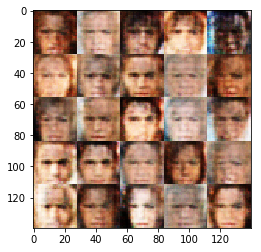

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7557


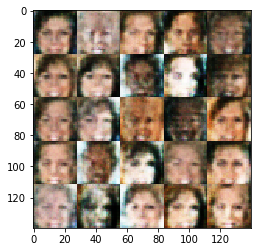

Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7984


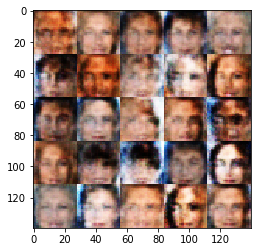

Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7747


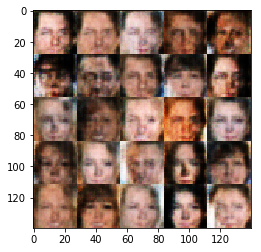

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7532


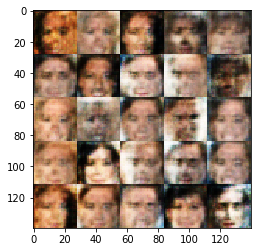

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7633


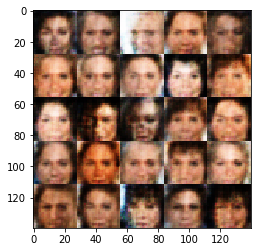

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7654


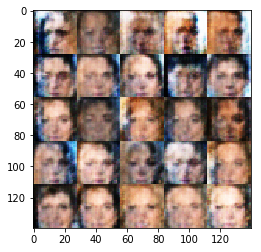

Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7775


In [34]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.